In [29]:
import numpy as np
import matplotlib.pyplot as plt
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "4"  # adjust for your machine and availability
import jax

os.listdir()
os.chdir("..")
from src.c3po.model.model import C3PO
from src.c3po.toy_model_generators.hmm import generate_hmm_spike_train
from src.c3po.toy_model_generators.phase import (
    generate_periodic_spike_train,
    generate_waveform_features,
)

In [30]:
latent_period = 3
noise_scale = 0.1
t_max = 5000
n_units = 64
n_channels = 128
max_wait_update = 0.3

mark_ids, mark_times, marks, template_waveforms, tuning_curves = (
    generate_periodic_spike_train(
        latent_period=latent_period,
        noise_scale=noise_scale,
        t_max=t_max,
        n_units=n_units,
        n_channels=n_channels,
        max_wait_update=max_wait_update,
    )
)

waited
waited
waited
waited
waited


KeyboardInterrupt: 

In [ ]:
t = np.arange(0, t_max, 0.001)
theta = np.mod(t, latent_period) / latent_period * 2 * np.pi

In [ ]:
n_noise_units = 32
for i in range(n_units - n_noise_units, n_units):
    ind = np.where(mark_ids == i)[0]
    new_times = np.random.uniform(0, t_max, size=len(ind))
    mark_times[ind] = new_times

# sort spikes by time
ind = np.argsort(mark_times)
mark_times = mark_times[ind]
mark_ids = mark_ids[ind]
marks = marks[ind]

In [ ]:
# n_noise_units = 4

# noise_template_waveforms = generate_waveform_features(
#     n_channels=n_channels, n_units=n_noise_units
# )

# noise_times = []
# noise_ids = []
# noise_marks = []
# for i in range(n_noise_units):
#     rate_hz = np.random.uniform(0.5, 2.0)
#     n_spikes = np.random.poisson(rate_hz * np.max(mark_times))
#     times_ = np.random.uniform(0, np.max(mark_times), size=n_spikes)
#     noise_times.extend(times_)
#     noise_ids.extend(np.ones_like(times_) * (i + mark_ids.max() + 1))
#     noise_marks.extend(
#         np.ones((n_spikes, n_channels)) * noise_template_waveforms[i]
#         + np.random.normal(0, noise_scale, size=(n_spikes, n_channels))
#     )

# merged_marks = np.vstack([marks, noise_marks])
# merged_times = np.hstack([mark_times, noise_times])
# merged_ids = np.hstack([mark_ids, noise_ids])

# sort_idx = np.argsort(merged_times)
# merged_times = merged_times[sort_idx]
# merged_ids = merged_ids[sort_idx].astype(int)
# merged_marks = merged_marks[sort_idx]

# Build Model

In [51]:
# prep data for model
from src.c3po.model.util import prep_training_data

delta_t = np.diff(mark_times)[None, ...]
x = marks[1:][None, ...]

sample_length = 2000
x_train, delta_t_train = prep_training_data(x, delta_t, sample_length)
i = sample_length

# hyperparams
latent_dim = 5
context_dim = 3
encoder_widths = [64, 32, 16, 8]

n_neg_samples = 32
encoder_args = dict(encoder_model="simple", widths=encoder_widths)
dilations = [
    1,
    2,
    4,
    8,
]
kernels = [8, 8, 16, 16]
# dilations = dilations * 2
# kernels = kernels * 2
context_args = dict(
    context_model="wavenet",
    layer_dilations=dilations,
    layer_kernel_size=kernels,
    expanded_dim=64,
    smoothing=2,
    smoothing_decay=1,
    categorical=False,
)


rate_args = dict(
    rate_model="bilinear",
)

# rate_args = dict(rate_model="sharedSpace")


# model = C3PO(encoder_args, context_args, rate_args, latent_dim, context_dim, n_neg_samples)
model = C3PO(
    encoder_args,
    context_args,
    rate_args,
    distribution="poisson",
    latent_dim=latent_dim,
    context_dim=context_dim,
    n_neg_samples=n_neg_samples,
    predicted_sequence_length=1,
    return_embeddings_in_call=True,
)

rand_key = jax.random.PRNGKey(0)
params = model.init(jax.random.PRNGKey(0), x, delta_t, rand_key)
run_model = jax.jit(model.apply)
x_train.shape

z_stacked (1, 1, 240823, 5)
Z (1, 240824, 5) pos_params (1, 1, 240823, 1)
neg_z (1, 32, 240824, 5)
c (1, 240824, 3)
neg_params (1, 32, 240823, 1)


(239, 2000, 128)

# Train Model

In [85]:
import optax
from tqdm import tqdm
from src.c3po.model.model import loss

learning_rate = 1e-3
batch_size = 64


def training_loss_fun(params, x, delta_t, rand_key):
    pos_params, neg_params, z, c, neg_z = run_model(params, x, delta_t, rand_key)
    return model.contrastive_loss(
        pos_params,
        neg_params,
        delta_t,
        z[:, 1:],
        neg_z,
    )


loss_grad_fn = jax.value_and_grad(training_loss_fun)


optimizer = optax.chain(
    # optax.clip_by_global_norm(1.0),
    optax.adam(learning_rate),
)

# Initialize parameters of the model + optimizer.
opt_state = optimizer.init(params)
# Run training loop.
tracked_loss = []
with tqdm() as pbar:
    for i in range(1000):
        ind = np.arange(x_train.shape[0])
        np.random.shuffle(ind)
        epoch_loss = []
        j = 0
        while j < x_train.shape[0]:
            # Perform one gradient update.
            rand_key, _ = jax.random.split(rand_key)
            batch_inds = ind[j : j + batch_size]
            loss_val, grads = loss_grad_fn(
                params, x_train[batch_inds], delta_t_train[batch_inds], rand_key
            )
            epoch_loss.append(loss_val)
            updates, opt_state = optimizer.update(grads, opt_state)
            params = optax.apply_updates(params, updates)
            j += batch_size
        tracked_loss.append(np.mean(epoch_loss))
        pbar.update(1)
        pbar.set_description(f"loss: {tracked_loss[-1]:.4f}")

loss: 2.8534: : 317it [15:56,  3.02s/it]


KeyboardInterrupt: 

Text(0, 0.5, 'Loss')

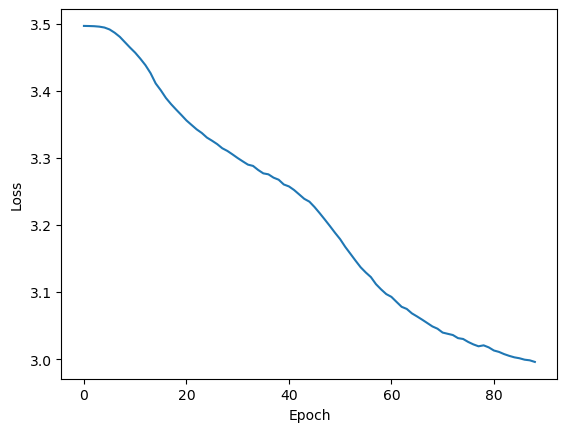

In [59]:
epoch = np.arange(len(tracked_loss))
plt.plot(epoch, tracked_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [ ]:
https://it.ucsf.edu/how-to/subscribe-listserv?check_logged_in=1

NEURO-POSTDOCS@LISTSRV.UCSF.EDU
NSDISTRIBUTION@LISTSRV.UCSF.EDU
TUESDAYSEMINAR@LISTSRV.UCSF.EDU

# Train V2

In [ ]:
from src.c3po.model.model import loss

distribution = "poisson"
predicted_sequence_length = 1


def change_n_neg_samples(params, x, delta_t, rand_key, n_neg_samples):
    model = C3PO(
        encoder_args,
        context_args,
        rate_args,
        distribution,
        latent_dim,
        context_dim,
        n_neg_samples,
        predicted_sequence_length,
        return_embeddings_in_call=True,
    )
    run_model = jax.jit(model.apply)

    def training_loss_fun(params, x, delta_t, rand_key):
        pos_params, neg_params, z, c, neg_z = run_model(params, x, delta_t, rand_key)
        return model.contrastive_loss(
            pos_params,
            neg_params,
            delta_t,
            z[:, predicted_sequence_length:],
            neg_z,
        )

    return jax.value_and_grad(training_loss_fun)


def training_loss_fun(params, x, delta_t, rand_key):
    model = C3PO(
        encoder_args,
        context_args,
        rate_args,
        distribution,
        latent_dim,
        context_dim,
        n_neg_samples,
        predicted_sequence_length,
        return_embeddings_in_call=True,
    )
    run_model = jax.jit(model.apply)

    pos_params, neg_params, z, c, neg_z = run_model(params, x, delta_t, rand_key)
    return model.contrastive_loss(
        pos_params,
        neg_params,
        delta_t,
        z[:, predicted_sequence_length:],
        neg_z,
    )


loss_grad_fn = jax.value_and_grad(training_loss_fun)

In [ ]:
from tqdm import tqdm
import optax

learning_rate = 1e-4
batch_size = 32
n_neg = 4

print(loss_grad_fn(params, x_train[:10], delta_t_train[:10], rand_key)[0])
import optax

optimizer = optax.chain(
    optax.adam(learning_rate),
)
# Initialize parameters of the model + optimizer.
opt_state = optimizer.init(params)


tracked_loss = []
buffer = 10
for i in range(5000):
    ind = np.arange(x_train.shape[0])
    np.random.shuffle(ind)
    epoch_loss = []
    j = 0
    with tqdm(
        total=x_train.shape[0], desc=f"Epoch {i+1}/{3000}", unit="samples"
    ) as pbar:
        prev_params = params.copy()  # store params from end of previous epoch
        while j < x_train.shape[0]:
            # Perform one gradient update.
            rand_key, _ = jax.random.split(rand_key)
            batch_inds = ind[j : j + batch_size]
            if len(batch_inds) < batch_size:
                break
            loss_val, grads = loss_grad_fn(
                params, x_train[batch_inds], delta_t_train[batch_inds], rand_key
            )
            if not np.isfinite(loss_val):
                params = prev_params.copy()
                raise ValueError("Loss is not finite")
            # print(loss_val)
            epoch_loss.append(loss_val)
            updates, opt_state = optimizer.update(grads, opt_state, params)
            params = optax.apply_updates(params, updates)
            j += batch_size

            pbar.update(batch_size)
            pbar.set_postfix(
                loss=np.mean(epoch_loss), n_neg=n_neg, batch_size=batch_size
            )
            # break
    tracked_loss.append(np.mean(epoch_loss))
    if i < 10:
        continue
    buffer -= 1
    if (np.mean(tracked_loss[-5:-1]) < tracked_loss[-1] * 1.01) and buffer <= 0:
        print("HI")
        if n_neg < 128:
            n_neg *= 2
            jax.clear_caches()
            del loss_grad_fn
            loss_grad_fn = change_n_neg_samples(
                params, x_train, delta_t_train, rand_key, n_neg
            )
            buffer = 5
        elif batch_size > 8:
            n_neg = 16
            batch_size = int(batch_size // 2)
            jax.clear_caches()
            del loss_grad_fn
            loss_grad_fn = change_n_neg_samples(
                params, x_train, delta_t_train, rand_key, n_neg
            )
            buffer = 5

z_stacked (10, 1, 1999, 3)
Z (10, 2000, 3) pos_params (10, 1, 1999, 1)
neg_z (10, 32, 2000, 3)
c (10, 2000, 3)
neg_params (10, 32, 1999, 1)
2.6765664


Epoch 1/3000:   0%|          | 0/43 [00:00<?, ?samples/s]

z_stacked (32, 1, 1999, 3)
Z (32, 2000, 3) pos_params (32, 1, 1999, 1)
neg_z (32, 32, 2000, 3)
c (32, 2000, 3)
neg_params (32, 32, 1999, 1)


Epoch 20/3000:  74%|███████▍  | 32/43 [00:00<00:00, 203.04samples/s, batch_size=32, loss=2.67, n_neg=4]


HI


Epoch 21/3000:   0%|          | 0/43 [00:00<?, ?samples/s]

z_stacked (32, 1, 1999, 3)
Z (32, 2000, 3) pos_params (32, 1, 1999, 1)
neg_z (32, 8, 2000, 3)
c (32, 2000, 3)
neg_params (32, 8, 1999, 1)


Epoch 25/3000:  74%|███████▍  | 32/43 [00:00<00:00, 206.95samples/s, batch_size=32, loss=1.46, n_neg=8]


HI


Epoch 26/3000:   0%|          | 0/43 [00:00<?, ?samples/s]

z_stacked (32, 1, 1999, 3)
Z (32, 2000, 3) pos_params (32, 1, 1999, 1)
neg_z (32, 16, 2000, 3)
c (32, 2000, 3)
neg_params (32, 16, 1999, 1)


Epoch 30/3000:  74%|███████▍  | 32/43 [00:00<00:00, 209.50samples/s, batch_size=32, loss=2.05, n_neg=16]


HI


Epoch 31/3000:   0%|          | 0/43 [00:00<?, ?samples/s]

z_stacked (32, 1, 1999, 3)
Z (32, 2000, 3) pos_params (32, 1, 1999, 1)
neg_z (32, 32, 2000, 3)
c (32, 2000, 3)
neg_params (32, 32, 1999, 1)


Epoch 35/3000:  74%|███████▍  | 32/43 [00:00<00:00, 211.59samples/s, batch_size=32, loss=2.67, n_neg=32]


HI


Epoch 36/3000:   0%|          | 0/43 [00:00<?, ?samples/s]

z_stacked (32, 1, 1999, 3)
Z (32, 2000, 3) pos_params (32, 1, 1999, 1)
neg_z (32, 64, 2000, 3)
c (32, 2000, 3)
neg_params (32, 64, 1999, 1)


Epoch 40/3000:  74%|███████▍  | 32/43 [00:00<00:00, 169.16samples/s, batch_size=32, loss=3.32, n_neg=64]


HI


Epoch 41/3000:   0%|          | 0/43 [00:00<?, ?samples/s]

z_stacked (32, 1, 1999, 3)
Z (32, 2000, 3) pos_params (32, 1, 1999, 1)
neg_z (32, 128, 2000, 3)
c (32, 2000, 3)
neg_params (32, 128, 1999, 1)


Epoch 45/3000:  74%|███████▍  | 32/43 [00:00<00:00, 111.69samples/s, batch_size=32, loss=4, n_neg=128]


HI


Epoch 46/3000:   0%|          | 0/43 [00:00<?, ?samples/s]

z_stacked (16, 1, 1999, 3)
Z (16, 2000, 3) pos_params (16, 1, 1999, 1)
neg_z (16, 16, 2000, 3)
c (16, 2000, 3)
neg_params (16, 16, 1999, 1)


Epoch 50/3000:  74%|███████▍  | 32/43 [00:00<00:00, 137.85samples/s, batch_size=16, loss=2.04, n_neg=16]


HI


Epoch 51/3000:   0%|          | 0/43 [00:00<?, ?samples/s]

z_stacked (16, 1, 1999, 3)
Z (16, 2000, 3) pos_params (16, 1, 1999, 1)
neg_z (16, 32, 2000, 3)
c (16, 2000, 3)
neg_params (16, 32, 1999, 1)


Epoch 55/3000:  74%|███████▍  | 32/43 [00:00<00:00, 128.05samples/s, batch_size=16, loss=2.67, n_neg=32]


HI


Epoch 56/3000:   0%|          | 0/43 [00:00<?, ?samples/s]

z_stacked (16, 1, 1999, 3)
Z (16, 2000, 3) pos_params (16, 1, 1999, 1)
neg_z (16, 64, 2000, 3)
c (16, 2000, 3)
neg_params (16, 64, 1999, 1)


Epoch 60/3000:  74%|███████▍  | 32/43 [00:00<00:00, 96.05samples/s, batch_size=16, loss=3.33, n_neg=64]


HI


Epoch 61/3000:   0%|          | 0/43 [00:00<?, ?samples/s]

z_stacked (16, 1, 1999, 3)
Z (16, 2000, 3) pos_params (16, 1, 1999, 1)
neg_z (16, 128, 2000, 3)
c (16, 2000, 3)
neg_params (16, 128, 1999, 1)


Epoch 65/3000:  74%|███████▍  | 32/43 [00:00<00:00, 72.09samples/s, batch_size=16, loss=4.01, n_neg=128]


HI


Epoch 66/3000:   0%|          | 0/43 [00:00<?, ?samples/s]

z_stacked (8, 1, 1999, 3)
Z (8, 2000, 3) pos_params (8, 1, 1999, 1)
neg_z (8, 16, 2000, 3)
c (8, 2000, 3)
neg_params (8, 16, 1999, 1)


Epoch 70/3000:  93%|█████████▎| 40/43 [00:00<00:00, 67.32samples/s, batch_size=8, loss=2.05, n_neg=16]


HI


Epoch 71/3000:   0%|          | 0/43 [00:00<?, ?samples/s]

z_stacked (8, 1, 1999, 3)
Z (8, 2000, 3) pos_params (8, 1, 1999, 1)
neg_z (8, 32, 2000, 3)
c (8, 2000, 3)
neg_params (8, 32, 1999, 1)


Epoch 75/3000:  93%|█████████▎| 40/43 [00:00<00:00, 66.84samples/s, batch_size=8, loss=2.67, n_neg=32]


HI


Epoch 76/3000:   0%|          | 0/43 [00:00<?, ?samples/s]

z_stacked (8, 1, 1999, 3)
Z (8, 2000, 3) pos_params (8, 1, 1999, 1)
neg_z (8, 64, 2000, 3)
c (8, 2000, 3)
neg_params (8, 64, 1999, 1)


Epoch 80/3000:  93%|█████████▎| 40/43 [00:00<00:00, 45.13samples/s, batch_size=8, loss=3.33, n_neg=64]


HI


Epoch 81/3000:   0%|          | 0/43 [00:00<?, ?samples/s]

z_stacked (8, 1, 1999, 3)
Z (8, 2000, 3) pos_params (8, 1, 1999, 1)
neg_z (8, 128, 2000, 3)
c (8, 2000, 3)
neg_params (8, 128, 1999, 1)


Epoch 85/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.59samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 86/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.32samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 87/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.13samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 88/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.55samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 89/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.53samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 90/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.44samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 91/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.70samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 92/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.19samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 93/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.04samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 94/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.10samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 95/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.12samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 96/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.33samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 97/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.57samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 98/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.42samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 99/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.35samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 100/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.65samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 101/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.35samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 102/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.47samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 103/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.96samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 104/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.36samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 105/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.69samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 106/3000:  93%|█████████▎| 40/43 [00:01<00:00, 35.30samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 107/3000:  93%|█████████▎| 40/43 [00:01<00:00, 24.14samples/s, batch_size=8, loss=4.02, n_neg=128]


HI


Epoch 108/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.76samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 109/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.53samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 110/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.50samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 111/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.72samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 112/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.45samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 113/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.26samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 114/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.94samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 115/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.85samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 116/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.60samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 117/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.77samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 118/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.48samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 119/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.68samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 120/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.27samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 121/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.66samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 122/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.38samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 123/3000:  93%|█████████▎| 40/43 [00:00<00:00, 40.91samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 124/3000:  93%|█████████▎| 40/43 [00:00<00:00, 40.36samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 125/3000:  93%|█████████▎| 40/43 [00:00<00:00, 40.60samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 126/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.77samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 127/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.80samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 128/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.62samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 129/3000:  93%|█████████▎| 40/43 [00:01<00:00, 35.28samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 130/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.72samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 131/3000:  93%|█████████▎| 40/43 [00:01<00:00, 35.27samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 132/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.17samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 133/3000:  93%|█████████▎| 40/43 [00:01<00:00, 26.91samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 134/3000:  93%|█████████▎| 40/43 [00:01<00:00, 40.00samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 135/3000:  93%|█████████▎| 40/43 [00:00<00:00, 40.22samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 136/3000:  93%|█████████▎| 40/43 [00:00<00:00, 40.72samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 137/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.49samples/s, batch_size=8, loss=4, n_neg=128]


HI


Epoch 138/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.56samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 139/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.62samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 140/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.59samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 141/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.21samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 142/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.38samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 143/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.75samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 144/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.72samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 145/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.29samples/s, batch_size=8, loss=4, n_neg=128]


HI


Epoch 146/3000:  93%|█████████▎| 40/43 [00:01<00:00, 35.12samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 147/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.55samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 148/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.51samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 149/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.31samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 150/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.02samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 151/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.24samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 152/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.47samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 153/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.72samples/s, batch_size=8, loss=4, n_neg=128]


HI


Epoch 154/3000:  93%|█████████▎| 40/43 [00:00<00:00, 40.03samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 155/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.37samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 156/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.88samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 157/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.79samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 158/3000:  93%|█████████▎| 40/43 [00:01<00:00, 40.00samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 159/3000:  93%|█████████▎| 40/43 [00:01<00:00, 26.74samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 160/3000:  93%|█████████▎| 40/43 [00:00<00:00, 40.03samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 161/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.63samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 162/3000:  93%|█████████▎| 40/43 [00:00<00:00, 40.19samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 163/3000:  93%|█████████▎| 40/43 [00:00<00:00, 40.24samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 164/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.77samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 165/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.62samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 166/3000:  93%|█████████▎| 40/43 [00:00<00:00, 40.28samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 167/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.61samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 168/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.36samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 169/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.26samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 170/3000:  93%|█████████▎| 40/43 [00:01<00:00, 32.88samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 171/3000:  93%|█████████▎| 40/43 [00:01<00:00, 35.38samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 172/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.39samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 173/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.82samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 174/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.00samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 175/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.50samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 176/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.44samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 177/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.67samples/s, batch_size=8, loss=4, n_neg=128]


HI


Epoch 178/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.82samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 179/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.37samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 180/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.79samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 181/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.54samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 182/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.32samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 183/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.20samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 184/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.73samples/s, batch_size=8, loss=4, n_neg=128]


HI


Epoch 185/3000:  93%|█████████▎| 40/43 [00:01<00:00, 26.60samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 186/3000:  93%|█████████▎| 40/43 [00:01<00:00, 40.00samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 187/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.74samples/s, batch_size=8, loss=4, n_neg=128]


HI


Epoch 188/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.14samples/s, batch_size=8, loss=4, n_neg=128]


HI


Epoch 189/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.78samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 190/3000:  93%|█████████▎| 40/43 [00:01<00:00, 35.16samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 191/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.07samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 192/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.67samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 193/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.85samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 194/3000:  93%|█████████▎| 40/43 [00:01<00:00, 35.58samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 195/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.44samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 196/3000:  93%|█████████▎| 40/43 [00:01<00:00, 35.01samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 197/3000:  93%|█████████▎| 40/43 [00:01<00:00, 35.13samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 198/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.29samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 199/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.93samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 200/3000:  93%|█████████▎| 40/43 [00:00<00:00, 40.26samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 201/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.47samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 202/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.12samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 203/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.87samples/s, batch_size=8, loss=4, n_neg=128]


HI


Epoch 204/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.02samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 205/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.83samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 206/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.74samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 207/3000:  93%|█████████▎| 40/43 [00:01<00:00, 35.00samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 208/3000:  93%|█████████▎| 40/43 [00:01<00:00, 35.51samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 209/3000:  93%|█████████▎| 40/43 [00:00<00:00, 40.00samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 210/3000:  93%|█████████▎| 40/43 [00:00<00:00, 40.17samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 211/3000:  93%|█████████▎| 40/43 [00:01<00:00, 24.50samples/s, batch_size=8, loss=4, n_neg=128]


HI


Epoch 212/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.05samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 213/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.77samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 214/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.73samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 215/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.69samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 216/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.84samples/s, batch_size=8, loss=4.01, n_neg=128]


HI


Epoch 217/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.26samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 218/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.95samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 219/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.93samples/s, batch_size=8, loss=4, n_neg=128]


HI


Epoch 220/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.59samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 221/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.43samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 222/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.47samples/s, batch_size=8, loss=4, n_neg=128]


HI


Epoch 223/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.53samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 224/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.92samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 225/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.13samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 226/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.27samples/s, batch_size=8, loss=4, n_neg=128]


HI


Epoch 227/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.65samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 228/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.54samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 229/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.38samples/s, batch_size=8, loss=4, n_neg=128]


HI


Epoch 230/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.18samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 231/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.48samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 232/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.22samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 233/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.76samples/s, batch_size=8, loss=4, n_neg=128]


HI


Epoch 234/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.93samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 235/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.74samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 236/3000:  93%|█████████▎| 40/43 [00:01<00:00, 35.21samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 237/3000:  93%|█████████▎| 40/43 [00:01<00:00, 23.57samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 238/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.26samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 239/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.36samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 240/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.89samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 241/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.29samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 242/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.53samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 243/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.51samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 244/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.37samples/s, batch_size=8, loss=4, n_neg=128]


HI


Epoch 245/3000:  93%|█████████▎| 40/43 [00:01<00:00, 35.64samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 246/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.06samples/s, batch_size=8, loss=4, n_neg=128]


HI


Epoch 247/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.03samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 248/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.18samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 249/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.13samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 250/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.73samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 251/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.13samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 252/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.95samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 253/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.53samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 254/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.65samples/s, batch_size=8, loss=4, n_neg=128]


HI


Epoch 255/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.97samples/s, batch_size=8, loss=4, n_neg=128]


HI


Epoch 256/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.09samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 257/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.55samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 258/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.80samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 259/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.18samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 260/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.55samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 261/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.30samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 262/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.58samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 263/3000:  93%|█████████▎| 40/43 [00:01<00:00, 26.87samples/s, batch_size=8, loss=4, n_neg=128]


HI


Epoch 264/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.86samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 265/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.41samples/s, batch_size=8, loss=4, n_neg=128]


HI


Epoch 266/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.39samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 267/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.35samples/s, batch_size=8, loss=4, n_neg=128]


HI


Epoch 268/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.88samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 269/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.15samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 270/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.79samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 271/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.56samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 272/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.10samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 273/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.28samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 274/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.47samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 275/3000:  93%|█████████▎| 40/43 [00:01<00:00, 35.65samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 276/3000:  93%|█████████▎| 40/43 [00:01<00:00, 35.10samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 277/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.52samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 278/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.31samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 279/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.17samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 280/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.07samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 281/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.83samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 282/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.77samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 283/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.37samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 284/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.84samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 285/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.92samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 286/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.08samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 287/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.48samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 288/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.29samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 289/3000:  93%|█████████▎| 40/43 [00:01<00:00, 23.19samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 290/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.63samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 291/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.70samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 292/3000:  93%|█████████▎| 40/43 [00:01<00:00, 35.06samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 293/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.16samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 294/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.20samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 295/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.06samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 296/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.55samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 297/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.92samples/s, batch_size=8, loss=4, n_neg=128]


HI


Epoch 298/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.19samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 299/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.12samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 300/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.30samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 301/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.69samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 302/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.89samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 303/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.60samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 304/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.29samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 305/3000:  93%|█████████▎| 40/43 [00:01<00:00, 35.08samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 306/3000:  93%|█████████▎| 40/43 [00:01<00:00, 35.46samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 307/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.33samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 308/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.52samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 309/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.03samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 310/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.39samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 311/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.19samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 312/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.11samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 313/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.94samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 314/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.83samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 315/3000:  93%|█████████▎| 40/43 [00:01<00:00, 25.51samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 316/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.24samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 317/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.64samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 318/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.73samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 319/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.66samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 320/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.20samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 321/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.44samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 322/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.44samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 323/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.74samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 324/3000:  93%|█████████▎| 40/43 [00:01<00:00, 35.15samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 325/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.30samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 326/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.74samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 327/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.46samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 328/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.61samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 329/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.25samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 330/3000:  93%|█████████▎| 40/43 [00:01<00:00, 35.17samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 331/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.68samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 332/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.00samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 333/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.01samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 334/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.48samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 335/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.44samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 336/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.01samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 337/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.08samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 338/3000:  93%|█████████▎| 40/43 [00:01<00:00, 32.37samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 339/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.26samples/s, batch_size=8, loss=4, n_neg=128]


HI


Epoch 340/3000:  93%|█████████▎| 40/43 [00:01<00:00, 35.54samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 341/3000:  93%|█████████▎| 40/43 [00:01<00:00, 23.42samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 342/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.13samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 343/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.32samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 344/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.83samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 345/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.18samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 346/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.70samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 347/3000:  93%|█████████▎| 40/43 [00:01<00:00, 30.41samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 348/3000:  93%|█████████▎| 40/43 [00:01<00:00, 31.59samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 349/3000:  93%|█████████▎| 40/43 [00:01<00:00, 31.16samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 350/3000:  93%|█████████▎| 40/43 [00:01<00:00, 31.07samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 351/3000:  93%|█████████▎| 40/43 [00:01<00:00, 32.16samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 352/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.05samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 353/3000:  93%|█████████▎| 40/43 [00:01<00:00, 32.26samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 354/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.45samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 355/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.12samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 356/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.10samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 357/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.23samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 358/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.62samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 359/3000:  93%|█████████▎| 40/43 [00:01<00:00, 32.27samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 360/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.06samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 361/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.62samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 362/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.42samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 363/3000:  93%|█████████▎| 40/43 [00:01<00:00, 35.61samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 364/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.54samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 365/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.82samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 366/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.45samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 367/3000:  93%|█████████▎| 40/43 [00:01<00:00, 25.87samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 368/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.79samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 369/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.84samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 370/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.04samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 371/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.84samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 372/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.91samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 373/3000:  93%|█████████▎| 40/43 [00:01<00:00, 35.74samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 374/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.78samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 375/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.35samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 376/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.14samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 377/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.05samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 378/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.43samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 379/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.18samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 380/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.31samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 381/3000:  93%|█████████▎| 40/43 [00:00<00:00, 40.21samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 382/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.74samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 383/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.38samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 384/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.16samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 385/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.81samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 386/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.01samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 387/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.45samples/s, batch_size=8, loss=4, n_neg=128]   


HI


Epoch 388/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.31samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 389/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.04samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 390/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.33samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 391/3000:  93%|█████████▎| 40/43 [00:01<00:00, 35.21samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 392/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.14samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 393/3000:  93%|█████████▎| 40/43 [00:01<00:00, 23.93samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 394/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.98samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 395/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.51samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 396/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.47samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 397/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.21samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 398/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.18samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 399/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.77samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 400/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.48samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 401/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.68samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 402/3000:  93%|█████████▎| 40/43 [00:01<00:00, 35.91samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 403/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.23samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 404/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.40samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 405/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.12samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 406/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.59samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 407/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.50samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 408/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.03samples/s, batch_size=8, loss=4, n_neg=128]


HI


Epoch 409/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.95samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 410/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.03samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 411/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.42samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 412/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.52samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 413/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.00samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 414/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.66samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 415/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.44samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 416/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.88samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 417/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.93samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 418/3000:  93%|█████████▎| 40/43 [00:01<00:00, 32.26samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 419/3000:  93%|█████████▎| 40/43 [00:01<00:00, 23.31samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 420/3000:  93%|█████████▎| 40/43 [00:01<00:00, 31.98samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 421/3000:  93%|█████████▎| 40/43 [00:01<00:00, 32.97samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 422/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.22samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 423/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.21samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 424/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.21samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 425/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.84samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 426/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.68samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 427/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.47samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 428/3000:  93%|█████████▎| 40/43 [00:01<00:00, 35.31samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 429/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.00samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 430/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.58samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 431/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.38samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 432/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.51samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 433/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.41samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 434/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.67samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 435/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.37samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 436/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.44samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 437/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.09samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 438/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.70samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 439/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.55samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 440/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.94samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 441/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.01samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 442/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.73samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 443/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.80samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 444/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.68samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 445/3000:  93%|█████████▎| 40/43 [00:01<00:00, 25.82samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 446/3000:  93%|█████████▎| 40/43 [00:01<00:00, 35.23samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 447/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.36samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 448/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.23samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 449/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.30samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 450/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.71samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 451/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.70samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 452/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.10samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 453/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.53samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 454/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.33samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 455/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.98samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 456/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.77samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 457/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.09samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 458/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.70samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 459/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.70samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 460/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.35samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 461/3000:  93%|█████████▎| 40/43 [00:01<00:00, 32.58samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 462/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.64samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 463/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.59samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 464/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.28samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 465/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.03samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 466/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.17samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 467/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.27samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 468/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.62samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 469/3000:  93%|█████████▎| 40/43 [00:01<00:00, 35.02samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 470/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.57samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 471/3000:  93%|█████████▎| 40/43 [00:01<00:00, 24.18samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 472/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.69samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 473/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.17samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 474/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.54samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 475/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.71samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 476/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.10samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 477/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.29samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 478/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.87samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 479/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.99samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 480/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.31samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 481/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.36samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 482/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.75samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 483/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.11samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 484/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.27samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 485/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.62samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 486/3000:  93%|█████████▎| 40/43 [00:01<00:00, 35.43samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 487/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.02samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 488/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.24samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 489/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.43samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 490/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.12samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 491/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.21samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 492/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.98samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 493/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.03samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 494/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.93samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 495/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.25samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 496/3000:  93%|█████████▎| 40/43 [00:01<00:00, 27.65samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 497/3000:  93%|█████████▎| 40/43 [00:01<00:00, 23.38samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 498/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.03samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 499/3000:  93%|█████████▎| 40/43 [00:01<00:00, 31.64samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 500/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.31samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 501/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.19samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 502/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.66samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 503/3000:  93%|█████████▎| 40/43 [00:01<00:00, 32.70samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 504/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.39samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 505/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.80samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 506/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.08samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 507/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.19samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 508/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.60samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 509/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.05samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 510/3000:  93%|█████████▎| 40/43 [00:01<00:00, 35.03samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 511/3000:  93%|█████████▎| 40/43 [00:01<00:00, 35.85samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 512/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.37samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 513/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.55samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 514/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.54samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 515/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.08samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 516/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.08samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 517/3000:  93%|█████████▎| 40/43 [00:01<00:00, 35.26samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 518/3000:  93%|█████████▎| 40/43 [00:01<00:00, 35.80samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 519/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.48samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 520/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.04samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 521/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.32samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 522/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.20samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 523/3000:  93%|█████████▎| 40/43 [00:01<00:00, 24.84samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 524/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.48samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 525/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.81samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 526/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.14samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 527/3000:  93%|█████████▎| 40/43 [00:01<00:00, 35.47samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 528/3000:  93%|█████████▎| 40/43 [00:01<00:00, 32.88samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 529/3000:  93%|█████████▎| 40/43 [00:01<00:00, 32.32samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 530/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.32samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 531/3000:  93%|█████████▎| 40/43 [00:01<00:00, 32.57samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 532/3000:  93%|█████████▎| 40/43 [00:01<00:00, 35.24samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 533/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.23samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 534/3000:  93%|█████████▎| 40/43 [00:01<00:00, 32.65samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 535/3000:  93%|█████████▎| 40/43 [00:01<00:00, 35.30samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 536/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.04samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 537/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.35samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 538/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.28samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 539/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.72samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 540/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.43samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 541/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.43samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 542/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.69samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 543/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.19samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 544/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.27samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 545/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.88samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 546/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.85samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 547/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.24samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 548/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.42samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 549/3000:  93%|█████████▎| 40/43 [00:01<00:00, 24.96samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 550/3000:  93%|█████████▎| 40/43 [00:01<00:00, 35.81samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 551/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.58samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 552/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.51samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 553/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.07samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 554/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.57samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 555/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.47samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 556/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.36samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 557/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.00samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 558/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.86samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 559/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.61samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 560/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.86samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 561/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.84samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 562/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.61samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 563/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.35samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 564/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.49samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 565/3000:  93%|█████████▎| 40/43 [00:01<00:00, 35.70samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 566/3000:  93%|█████████▎| 40/43 [00:01<00:00, 35.34samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 567/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.38samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 568/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.59samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 569/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.84samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 570/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.34samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 571/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.67samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 572/3000:  93%|█████████▎| 40/43 [00:01<00:00, 32.71samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 573/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.04samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 574/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.50samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 575/3000:  93%|█████████▎| 40/43 [00:01<00:00, 23.08samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 576/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.27samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 577/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.96samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 578/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.59samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 579/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.69samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 580/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.05samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 581/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.40samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 582/3000:  93%|█████████▎| 40/43 [00:01<00:00, 35.70samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 583/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.82samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 584/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.82samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 585/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.87samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 586/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.78samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 587/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.89samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 588/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.63samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 589/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.81samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 590/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.85samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 591/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.74samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 592/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.93samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 593/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.76samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 594/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.52samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 595/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.45samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 596/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.65samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 597/3000:  93%|█████████▎| 40/43 [00:01<00:00, 32.59samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 598/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.54samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 599/3000:  93%|█████████▎| 40/43 [00:01<00:00, 32.98samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 600/3000:  93%|█████████▎| 40/43 [00:01<00:00, 32.83samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 601/3000:  93%|█████████▎| 40/43 [00:01<00:00, 25.04samples/s, batch_size=8, loss=3.99, n_neg=128]


HI


Epoch 602/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.39samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 603/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.21samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 604/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.48samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 605/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.21samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 606/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.27samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 607/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.48samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 608/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.20samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 609/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.20samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 610/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.18samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 611/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.45samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 612/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.35samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 613/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.09samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 614/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.33samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 615/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.13samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 616/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.55samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 617/3000:  93%|█████████▎| 40/43 [00:01<00:00, 32.59samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 618/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.92samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 619/3000:  93%|█████████▎| 40/43 [00:01<00:00, 32.91samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 620/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.62samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 621/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.85samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 622/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.11samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 623/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.84samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 624/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.86samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 625/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.09samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 626/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.33samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 627/3000:  93%|█████████▎| 40/43 [00:01<00:00, 24.17samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 628/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.44samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 629/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.14samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 630/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.44samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 631/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.21samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 632/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.22samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 633/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.11samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 634/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.63samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 635/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.52samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 636/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.90samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 637/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.41samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 638/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.75samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 639/3000:  93%|█████████▎| 40/43 [00:01<00:00, 31.81samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 640/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.29samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 641/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.78samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 642/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.45samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 643/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.96samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 644/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.13samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 645/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.99samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 646/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.65samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 647/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.71samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 648/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.57samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 649/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.08samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 650/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.89samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 651/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.55samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 652/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.66samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 653/3000:  93%|█████████▎| 40/43 [00:01<00:00, 23.54samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 654/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.11samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 655/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.52samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 656/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.76samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 657/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.05samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 658/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.71samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 659/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.07samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 660/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.91samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 661/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.45samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 662/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.65samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 663/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.23samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 664/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.86samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 665/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.32samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 666/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.56samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 667/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.17samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 668/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.74samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 669/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.56samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 670/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.39samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 671/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.64samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 672/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.24samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 673/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.16samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 674/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.38samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 675/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.45samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 676/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.58samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 677/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.18samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 678/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.22samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 679/3000:  93%|█████████▎| 40/43 [00:01<00:00, 24.29samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 680/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.82samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 681/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.19samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 682/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.44samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 683/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.16samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 684/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.42samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 685/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.40samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 686/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.89samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 687/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.67samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 688/3000:  93%|█████████▎| 40/43 [00:01<00:00, 35.97samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 689/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.84samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 690/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.12samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 691/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.08samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 692/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.83samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 693/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.10samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 694/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.15samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 695/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.66samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 696/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.05samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 697/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.57samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 698/3000:  93%|█████████▎| 40/43 [00:01<00:00, 32.22samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 699/3000:  93%|█████████▎| 40/43 [00:01<00:00, 31.75samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 700/3000:  93%|█████████▎| 40/43 [00:01<00:00, 25.91samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 701/3000:  93%|█████████▎| 40/43 [00:01<00:00, 27.82samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 702/3000:  93%|█████████▎| 40/43 [00:01<00:00, 32.29samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 703/3000:  93%|█████████▎| 40/43 [00:01<00:00, 26.84samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 704/3000:  93%|█████████▎| 40/43 [00:01<00:00, 27.41samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 705/3000:  93%|█████████▎| 40/43 [00:01<00:00, 20.02samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 706/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.31samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 707/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.60samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 708/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.39samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 709/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.54samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 710/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.39samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 711/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.79samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 712/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.13samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 713/3000:  93%|█████████▎| 40/43 [00:01<00:00, 35.94samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 714/3000:  93%|█████████▎| 40/43 [00:01<00:00, 31.97samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 715/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.71samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 716/3000:  93%|█████████▎| 40/43 [00:01<00:00, 31.63samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 717/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.88samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 718/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.70samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 719/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.16samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 720/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.22samples/s, batch_size=8, loss=3.98, n_neg=128]


HI


Epoch 721/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.34samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 722/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.31samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 723/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.26samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 724/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.42samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 725/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.17samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 726/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.50samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 727/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.36samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 728/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.01samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 729/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.19samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 730/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.99samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 731/3000:  93%|█████████▎| 40/43 [00:01<00:00, 23.56samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 732/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.71samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 733/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.38samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 734/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.15samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 735/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.06samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 736/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.33samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 737/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.92samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 738/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.40samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 739/3000:  93%|█████████▎| 40/43 [00:01<00:00, 35.90samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 740/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.94samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 741/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.04samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 742/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.62samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 743/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.47samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 744/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.39samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 745/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.19samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 746/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.07samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 747/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.34samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 748/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.85samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 749/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.59samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 750/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.49samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 751/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.96samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 752/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.87samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 753/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.46samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 754/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.04samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 755/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.90samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 756/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.64samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 757/3000:  93%|█████████▎| 40/43 [00:01<00:00, 25.22samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 758/3000:  93%|█████████▎| 40/43 [00:01<00:00, 35.17samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 759/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.45samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 760/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.86samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 761/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.04samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 762/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.53samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 763/3000:  93%|█████████▎| 40/43 [00:01<00:00, 35.06samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 764/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.81samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 765/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.01samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 766/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.90samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 767/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.59samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 768/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.74samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 769/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.66samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 770/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.81samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 771/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.10samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 772/3000:  93%|█████████▎| 40/43 [00:01<00:00, 32.82samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 773/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.77samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 774/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.35samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 775/3000:  93%|█████████▎| 40/43 [00:01<00:00, 32.30samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 776/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.16samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 777/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.12samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 778/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.04samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 779/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.40samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 780/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.06samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 781/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.49samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 782/3000:  93%|█████████▎| 40/43 [00:01<00:00, 32.85samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 783/3000:  93%|█████████▎| 40/43 [00:01<00:00, 23.96samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 784/3000:  93%|█████████▎| 40/43 [00:01<00:00, 32.90samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 785/3000:  93%|█████████▎| 40/43 [00:01<00:00, 32.45samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 786/3000:  93%|█████████▎| 40/43 [00:01<00:00, 32.47samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 787/3000:  93%|█████████▎| 40/43 [00:01<00:00, 32.96samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 788/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.33samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 789/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.94samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 790/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.95samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 791/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.11samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 792/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.18samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 793/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.07samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 794/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.35samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 795/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.55samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 796/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.50samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 797/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.20samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 798/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.61samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 799/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.36samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 800/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.10samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 801/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.85samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 802/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.37samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 803/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.16samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 804/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.83samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 805/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.34samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 806/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.17samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 807/3000:  93%|█████████▎| 40/43 [00:01<00:00, 31.18samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 808/3000:  93%|█████████▎| 40/43 [00:01<00:00, 35.98samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 809/3000:  93%|█████████▎| 40/43 [00:01<00:00, 24.21samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 810/3000:  93%|█████████▎| 40/43 [00:01<00:00, 32.67samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 811/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.08samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 812/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.87samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 813/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.11samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 814/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.45samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 815/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.37samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 816/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.74samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 817/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.31samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 818/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.62samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 819/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.70samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 820/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.20samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 821/3000:  93%|█████████▎| 40/43 [00:01<00:00, 32.33samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 822/3000:  93%|█████████▎| 40/43 [00:01<00:00, 32.82samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 823/3000:  93%|█████████▎| 40/43 [00:01<00:00, 31.27samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 824/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.37samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 825/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.51samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 826/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.62samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 827/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.81samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 828/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.56samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 829/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.90samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 830/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.84samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 831/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.40samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 832/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.53samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 833/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.08samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 834/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.98samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 835/3000:  93%|█████████▎| 40/43 [00:01<00:00, 25.87samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 836/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.87samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 837/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.27samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 838/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.29samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 839/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.97samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 840/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.47samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 841/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.00samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 842/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.81samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 843/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.06samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 844/3000:  93%|█████████▎| 40/43 [00:01<00:00, 26.63samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 845/3000:  93%|█████████▎| 40/43 [00:01<00:00, 27.66samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 846/3000:  93%|█████████▎| 40/43 [00:01<00:00, 30.13samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 847/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.37samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 848/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.46samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 849/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.92samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 850/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.94samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 851/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.47samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 852/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.84samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 853/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.35samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 854/3000:  93%|█████████▎| 40/43 [00:01<00:00, 32.91samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 855/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.13samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 856/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.03samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 857/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.71samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 858/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.54samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 859/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.92samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 860/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.99samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 861/3000:  93%|█████████▎| 40/43 [00:01<00:00, 27.09samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 862/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.22samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 863/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.42samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 864/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.19samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 865/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.24samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 866/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.15samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 867/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.60samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 868/3000:  93%|█████████▎| 40/43 [00:01<00:00, 35.87samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 869/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.08samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 870/3000:  93%|█████████▎| 40/43 [00:01<00:00, 32.80samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 871/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.00samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 872/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.69samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 873/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.80samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 874/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.88samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 875/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.49samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 876/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.57samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 877/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.65samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 878/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.38samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 879/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.96samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 880/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.13samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 881/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.27samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 882/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.51samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 883/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.23samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 884/3000:  93%|█████████▎| 40/43 [00:01<00:00, 32.87samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 885/3000:  93%|█████████▎| 40/43 [00:01<00:00, 29.54samples/s, batch_size=8, loss=3.97, n_neg=128]


HI


Epoch 886/3000:  93%|█████████▎| 40/43 [00:01<00:00, 35.70samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 887/3000:  93%|█████████▎| 40/43 [00:01<00:00, 26.01samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 888/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.51samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 889/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.52samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 890/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.69samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 891/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.59samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 892/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.95samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 893/3000:  93%|█████████▎| 40/43 [00:01<00:00, 35.04samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 894/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.44samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 895/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.63samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 896/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.48samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 897/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.32samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 898/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.22samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 899/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.91samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 900/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.39samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 901/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.67samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 902/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.56samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 903/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.21samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 904/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.44samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 905/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.62samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 906/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.47samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 907/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.81samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 908/3000:  93%|█████████▎| 40/43 [00:01<00:00, 35.50samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 909/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.47samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 910/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.07samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 911/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.41samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 912/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.26samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 913/3000:  93%|█████████▎| 40/43 [00:01<00:00, 26.26samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 914/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.22samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 915/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.72samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 916/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.22samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 917/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.48samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 918/3000:  93%|█████████▎| 40/43 [00:01<00:00, 39.43samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 919/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.75samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 920/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.65samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 921/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.03samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 922/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.78samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 923/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.36samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 924/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.84samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 925/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.61samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 926/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.68samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 927/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.31samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 928/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.13samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 929/3000:  93%|█████████▎| 40/43 [00:01<00:00, 35.35samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 930/3000:  93%|█████████▎| 40/43 [00:01<00:00, 32.12samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 931/3000:  93%|█████████▎| 40/43 [00:01<00:00, 35.98samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 932/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.00samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 933/3000:  93%|█████████▎| 40/43 [00:01<00:00, 35.72samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 934/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.05samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 935/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.72samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 936/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.54samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 937/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.90samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 938/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.38samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 939/3000:  93%|█████████▎| 40/43 [00:01<00:00, 25.38samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 940/3000:  93%|█████████▎| 40/43 [00:01<00:00, 31.73samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 941/3000:  93%|█████████▎| 40/43 [00:01<00:00, 25.71samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 942/3000:  93%|█████████▎| 40/43 [00:01<00:00, 29.19samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 943/3000:  93%|█████████▎| 40/43 [00:01<00:00, 32.02samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 944/3000:  93%|█████████▎| 40/43 [00:01<00:00, 32.41samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 945/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.62samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 946/3000:  93%|█████████▎| 40/43 [00:01<00:00, 35.77samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 947/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.09samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 948/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.50samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 949/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.47samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 950/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.41samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 951/3000:  93%|█████████▎| 40/43 [00:01<00:00, 32.55samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 952/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.44samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 953/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.08samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 954/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.46samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 955/3000:  93%|█████████▎| 40/43 [00:01<00:00, 32.74samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 956/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.30samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 957/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.80samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 958/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.54samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 959/3000:  93%|█████████▎| 40/43 [00:01<00:00, 35.62samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 960/3000:  93%|█████████▎| 40/43 [00:01<00:00, 32.29samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 961/3000:  93%|█████████▎| 40/43 [00:01<00:00, 32.46samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 962/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.95samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 963/3000:  93%|█████████▎| 40/43 [00:01<00:00, 32.35samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 964/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.21samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 965/3000:  93%|█████████▎| 40/43 [00:01<00:00, 27.21samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 966/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.40samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 967/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.73samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 968/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.10samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 969/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.39samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 970/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.92samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 971/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.69samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 972/3000:  93%|█████████▎| 40/43 [00:01<00:00, 32.20samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 973/3000:  93%|█████████▎| 40/43 [00:01<00:00, 28.25samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 974/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.37samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 975/3000:  93%|█████████▎| 40/43 [00:01<00:00, 25.18samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 976/3000:  93%|█████████▎| 40/43 [00:01<00:00, 26.39samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 977/3000:  93%|█████████▎| 40/43 [00:01<00:00, 24.32samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 978/3000:  93%|█████████▎| 40/43 [00:01<00:00, 27.93samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 979/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.78samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 980/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.92samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 981/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.72samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 982/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.19samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 983/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.64samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 984/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.75samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 985/3000:  93%|█████████▎| 40/43 [00:01<00:00, 35.93samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 986/3000:  93%|█████████▎| 40/43 [00:01<00:00, 32.40samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 987/3000:  93%|█████████▎| 40/43 [00:01<00:00, 32.69samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 988/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.88samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 989/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.43samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 990/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.48samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 991/3000:  93%|█████████▎| 40/43 [00:01<00:00, 23.74samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 992/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.26samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 993/3000:  93%|█████████▎| 40/43 [00:01<00:00, 35.38samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 994/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.89samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 995/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.88samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 996/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.87samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 997/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.21samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 998/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.02samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 999/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.37samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 1000/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.79samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 1001/3000:  93%|█████████▎| 40/43 [00:01<00:00, 32.94samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1002/3000:  93%|█████████▎| 40/43 [00:01<00:00, 35.43samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1003/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.62samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1004/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.67samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1005/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.24samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1006/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.78samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1007/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.59samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1008/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.40samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1009/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.60samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1010/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.53samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1011/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.85samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1012/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.30samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1013/3000:  93%|█████████▎| 40/43 [00:01<00:00, 35.51samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1014/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.48samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1015/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.76samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1016/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.35samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1017/3000:  93%|█████████▎| 40/43 [00:01<00:00, 23.23samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1018/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.08samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1019/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.97samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 1020/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.35samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1021/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.69samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1022/3000:  93%|█████████▎| 40/43 [00:01<00:00, 32.92samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1023/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.17samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1024/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.23samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1025/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.32samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1026/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.26samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1027/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.10samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1028/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.97samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1029/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.97samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1030/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.28samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1031/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.55samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1032/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.06samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1033/3000:  93%|█████████▎| 40/43 [00:01<00:00, 35.58samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1034/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.93samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1035/3000:  93%|█████████▎| 40/43 [00:01<00:00, 32.85samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1036/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.57samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1037/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.16samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 1038/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.87samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1039/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.95samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1040/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.14samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1041/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.40samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1042/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.79samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1043/3000:  93%|█████████▎| 40/43 [00:01<00:00, 26.11samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1044/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.45samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1045/3000:  93%|█████████▎| 40/43 [00:01<00:00, 31.70samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1046/3000:  93%|█████████▎| 40/43 [00:01<00:00, 32.65samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1047/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.82samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1048/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.86samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1049/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.53samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1050/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.65samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1051/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.78samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 1052/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.64samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1053/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.80samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1054/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.96samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1055/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.94samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1056/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.46samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1057/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.89samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1058/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.50samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1059/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.01samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1060/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.56samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1061/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.35samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1062/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.67samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1063/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.45samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1064/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.76samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1065/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.91samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1066/3000:  93%|█████████▎| 40/43 [00:01<00:00, 32.75samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1067/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.72samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1068/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.63samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1069/3000:  93%|█████████▎| 40/43 [00:01<00:00, 26.07samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1070/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.35samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1071/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.26samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1072/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.37samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1073/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.71samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1074/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.14samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1075/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.54samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1076/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.54samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1077/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.09samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1078/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.83samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1079/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.58samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1080/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.09samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1081/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.17samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1082/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.74samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1083/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.04samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1084/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.94samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1085/3000:  93%|█████████▎| 40/43 [00:01<00:00, 32.84samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1086/3000:  93%|█████████▎| 40/43 [00:01<00:00, 32.72samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1087/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.35samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1088/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.18samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1089/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.56samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1090/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.54samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1091/3000:  93%|█████████▎| 40/43 [00:01<00:00, 32.88samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1092/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.82samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1093/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.53samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1094/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.94samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1095/3000:  93%|█████████▎| 40/43 [00:01<00:00, 26.76samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1096/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.91samples/s, batch_size=8, loss=3.96, n_neg=128]


HI


Epoch 1097/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.80samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1098/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.48samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1099/3000:  93%|█████████▎| 40/43 [00:01<00:00, 35.83samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1100/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.39samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1101/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.60samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1102/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.99samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1103/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.74samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1104/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.28samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1105/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.10samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1106/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.42samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1107/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.87samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1108/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.93samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1109/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.35samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1110/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.31samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1111/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.97samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1112/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.64samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1113/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.42samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1114/3000:  93%|█████████▎| 40/43 [00:01<00:00, 35.20samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1115/3000:  93%|█████████▎| 40/43 [00:01<00:00, 32.88samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1116/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.60samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1117/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.90samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1118/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.05samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1119/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.04samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1120/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.87samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1121/3000:  93%|█████████▎| 40/43 [00:01<00:00, 25.87samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1122/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.77samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1123/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.24samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1124/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.36samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1125/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.38samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1126/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.87samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1127/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.80samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1128/3000:  93%|█████████▎| 40/43 [00:01<00:00, 32.67samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1129/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.44samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1130/3000:  93%|█████████▎| 40/43 [00:01<00:00, 32.60samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1131/3000:  93%|█████████▎| 40/43 [00:01<00:00, 32.53samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1132/3000:  93%|█████████▎| 40/43 [00:01<00:00, 32.52samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1133/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.44samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1134/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.45samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1135/3000:  93%|█████████▎| 40/43 [00:01<00:00, 32.97samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1136/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.48samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1137/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.51samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1138/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.05samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1139/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.97samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1140/3000:  93%|█████████▎| 40/43 [00:01<00:00, 35.49samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1141/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.95samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1142/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.41samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1143/3000:  93%|█████████▎| 40/43 [00:01<00:00, 32.52samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1144/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.88samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1145/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.98samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1146/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.75samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1147/3000:  93%|█████████▎| 40/43 [00:01<00:00, 24.65samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1148/3000:  93%|█████████▎| 40/43 [00:01<00:00, 32.85samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1149/3000:  93%|█████████▎| 40/43 [00:01<00:00, 31.86samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1150/3000:  93%|█████████▎| 40/43 [00:01<00:00, 32.06samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1151/3000:  93%|█████████▎| 40/43 [00:01<00:00, 31.83samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1152/3000:  93%|█████████▎| 40/43 [00:01<00:00, 30.68samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1153/3000:  93%|█████████▎| 40/43 [00:01<00:00, 26.36samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1154/3000:  93%|█████████▎| 40/43 [00:01<00:00, 30.01samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1155/3000:  93%|█████████▎| 40/43 [00:01<00:00, 32.91samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1156/3000:  93%|█████████▎| 40/43 [00:01<00:00, 32.61samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1157/3000:  93%|█████████▎| 40/43 [00:01<00:00, 32.75samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1158/3000:  93%|█████████▎| 40/43 [00:01<00:00, 31.43samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1159/3000:  93%|█████████▎| 40/43 [00:01<00:00, 27.24samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1160/3000:  93%|█████████▎| 40/43 [00:01<00:00, 26.17samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1161/3000:  93%|█████████▎| 40/43 [00:01<00:00, 23.63samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1162/3000:  93%|█████████▎| 40/43 [00:01<00:00, 24.65samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1163/3000:  93%|█████████▎| 40/43 [00:01<00:00, 23.95samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1164/3000:  93%|█████████▎| 40/43 [00:01<00:00, 24.01samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1165/3000:  93%|█████████▎| 40/43 [00:01<00:00, 24.01samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1166/3000:  93%|█████████▎| 40/43 [00:01<00:00, 24.75samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1167/3000:  93%|█████████▎| 40/43 [00:01<00:00, 24.38samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1168/3000:  93%|█████████▎| 40/43 [00:01<00:00, 32.99samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1169/3000:  93%|█████████▎| 40/43 [00:01<00:00, 27.37samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1170/3000:  93%|█████████▎| 40/43 [00:01<00:00, 25.43samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1171/3000:  93%|█████████▎| 40/43 [00:01<00:00, 25.21samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1172/3000:  93%|█████████▎| 40/43 [00:01<00:00, 26.00samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1173/3000:  93%|█████████▎| 40/43 [00:01<00:00, 21.68samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1174/3000:  93%|█████████▎| 40/43 [00:01<00:00, 29.26samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1175/3000:  93%|█████████▎| 40/43 [00:01<00:00, 27.71samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1176/3000:  93%|█████████▎| 40/43 [00:01<00:00, 25.14samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1177/3000:  93%|█████████▎| 40/43 [00:01<00:00, 30.87samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1178/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.60samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1179/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.68samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1180/3000:  93%|█████████▎| 40/43 [00:01<00:00, 35.04samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1181/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.33samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1182/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.60samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1183/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.24samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1184/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.11samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1185/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.22samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1186/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.81samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1187/3000:  93%|█████████▎| 40/43 [00:01<00:00, 32.04samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1188/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.50samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1189/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.73samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1190/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.29samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1191/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.71samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1192/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.32samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1193/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.03samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1194/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.69samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1195/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.80samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1196/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.57samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1197/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.29samples/s, batch_size=8, loss=3.93, n_neg=128]


HI


Epoch 1198/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.39samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1199/3000:  93%|█████████▎| 40/43 [00:01<00:00, 25.78samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1200/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.91samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1201/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.97samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1202/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.64samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1203/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.93samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1204/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.10samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1205/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.97samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1206/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.93samples/s, batch_size=8, loss=3.95, n_neg=128]


HI


Epoch 1207/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.84samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1208/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.28samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1209/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.93samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1210/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.06samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1211/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.66samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1212/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.40samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1213/3000:  93%|█████████▎| 40/43 [00:01<00:00, 35.26samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1214/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.91samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1215/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.70samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1216/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.27samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1217/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.93samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1218/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.75samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1219/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.98samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1220/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.24samples/s, batch_size=8, loss=3.93, n_neg=128]


HI


Epoch 1221/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.31samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1222/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.36samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1223/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.40samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1224/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.78samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1225/3000:  93%|█████████▎| 40/43 [00:01<00:00, 26.13samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1226/3000:  93%|█████████▎| 40/43 [00:01<00:00, 33.01samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1227/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.27samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1228/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.25samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1229/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.36samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1230/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.55samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1231/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.66samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1232/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.12samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1233/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.61samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1234/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.11samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1235/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.86samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1236/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.02samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1237/3000:  93%|█████████▎| 40/43 [00:01<00:00, 35.91samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1238/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.28samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1239/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.63samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1240/3000:  93%|█████████▎| 40/43 [00:01<00:00, 32.90samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1241/3000:  93%|█████████▎| 40/43 [00:01<00:00, 32.59samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1242/3000:  93%|█████████▎| 40/43 [00:01<00:00, 36.81samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1243/3000:  93%|█████████▎| 40/43 [00:01<00:00, 38.76samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1244/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.79samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1245/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.84samples/s, batch_size=8, loss=3.93, n_neg=128]


HI


Epoch 1246/3000:  93%|█████████▎| 40/43 [00:01<00:00, 34.40samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1247/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.83samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1248/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.66samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1249/3000:  93%|█████████▎| 40/43 [00:01<00:00, 37.49samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1250/3000:  93%|█████████▎| 40/43 [00:01<00:00, 35.92samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1251/3000:  93%|█████████▎| 40/43 [00:01<00:00, 25.74samples/s, batch_size=8, loss=3.94, n_neg=128]


HI


Epoch 1252/3000:  74%|███████▍  | 32/43 [00:00<00:00, 36.09samples/s, batch_size=8, loss=3.94, n_neg=128]


KeyboardInterrupt: 

# Analyze results

In [86]:
from src.c3po.analysis.analysis import C3poAnalysis

model_args = dict(
    encoder_args=encoder_args,
    context_args=context_args,
    rate_args=rate_args,
    distribution="poisson",
    latent_dim=latent_dim,
    context_dim=context_dim,
    n_neg_samples=n_neg_samples,
    predicted_sequence_length=1,
    sample_params=None,
)
analysis = C3poAnalysis(
    model=model,
    model_args=model_args,
    params=params,
)

In [87]:
analysis.embed_data(x, delta_t, first_mark_time=0, chunk_size=5000, delta_t_units="s")
analysis.fit_context_pca()
t_interp = np.arange(analysis.t[0], analysis.t[-1], 0.001)
analysis.interpolate_context(t_interp)
analysis.embed_context_pca()

 98%|█████████▊| 235000/240824 [00:02<00:00, 107745.91it/s]


### Example trace

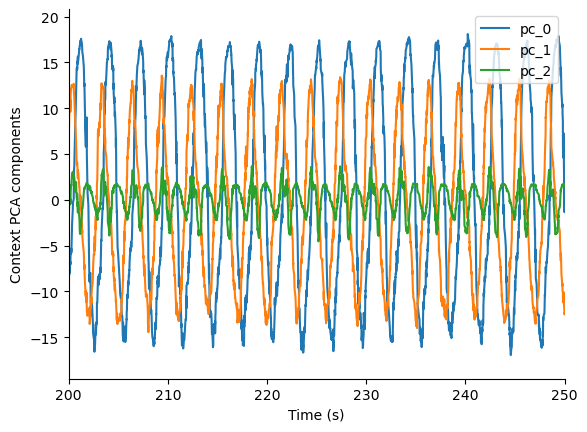

In [88]:
# example context trace
for i in range(context_dim):
    plt.plot(
        analysis.t,
        analysis.c_pca[:, i],
        label=f"pc_{i}",
    )
plt.legend(loc=1)
plt.xlabel("Time (s)")
plt.ylabel("Context PCA components")
plt.xlim(200, 250)
ax = plt.gca()
ax.spines[["top", "right"]].set_visible(False)

### Context-phase relationship

Text(0.5, 0, 'Latent phase (rad)')

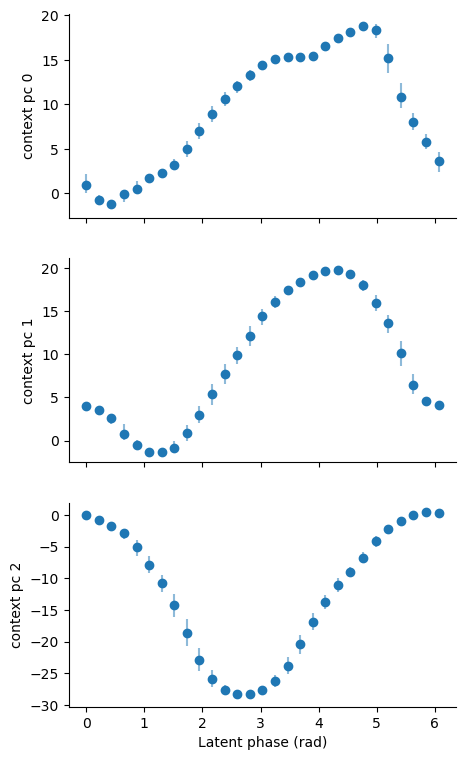

In [89]:
c_binned, bins = analysis.bin_context_by_feature(theta, t)

fig, ax = plt.subplots(
    nrows=context_dim, ncols=1, figsize=(5, 3 * context_dim), sharex=True
)

for i in range(context_dim):
    ax[i].scatter(bins[:-1], [np.median(cc[:, i]) for cc in c_binned])
    lo = [np.percentile(cc[:, i], 25) for cc in c_binned]
    hi = [np.percentile(cc[:, i], 75) for cc in c_binned]
    ax[i].vlines(bins[:-1], lo, hi, color="C0", alpha=0.5)
    ax[i].set_ylabel(f"context pc {i}")
    ax[i].spines[["top", "right"]].set_visible(False)

plt.xlabel("Latent phase (rad)")

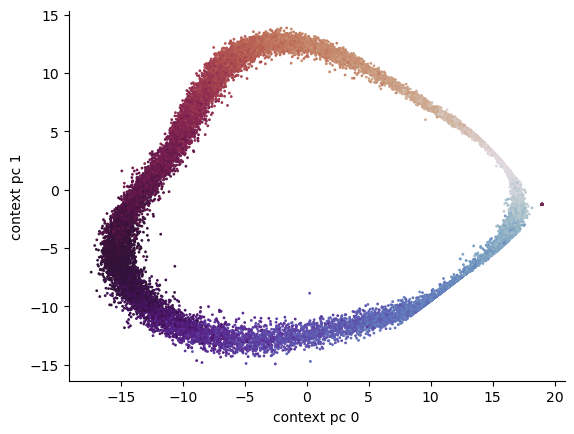

In [ ]:
# Context embedding
subset = 10
mark_phase_ind = np.digitize(analysis.t, t) - 1
mark_phase = theta[mark_phase_ind]
plt.scatter(
    analysis.c_pca[::subset, 0],
    analysis.c_pca[::subset, 1],
    c=mark_phase[::subset],
    s=1,
    cmap="twilight",
)
plt.xlabel("context pc 0")
plt.ylabel("context pc 1")
ax = plt.gca()
ax.spines[["top", "right"]].set_visible(False)

### Waveform embedding (Codes for tuning information, NOT waveform voltages)

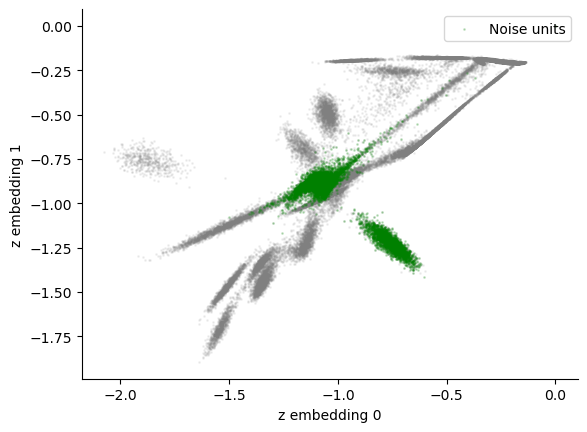

In [ ]:
z = analysis.z.copy()
subset = 2

from sklearn.decomposition import PCA

pca = PCA(n_components=latent_dim)
pca.fit(z)
# pca = analysis.pca
# z = pca.transform(z)

ids = mark_ids[1:]
# feature = template_waveforms[ids].argmax(axis=1)
plt.scatter(
    z[::subset, 0], z[::subset, 1], s=1, alpha=0.1, c="grey"
)  # c=feature, cmap="jet")

ind_noise = np.where(ids >= mark_ids.max() - n_noise_units)[0][::subset]
plt.scatter(
    z[ind_noise, 0], z[ind_noise, 1], s=1, alpha=0.2, c="green", label="Noise units"
)
# plt.colorbar(label="Channel of max amplitude")
plt.xlabel("z embedding 0")
plt.ylabel("z embedding 1")
plt.legend(loc=1)
ax = plt.gca()
ax.spines[["top", "right"]].set_visible(False)

# plt.title("Waveform Embedding NOT organized by waveform shape")

Text(0.5, 1.0, 'Waveform Embedding NOT organized by waveform shape')

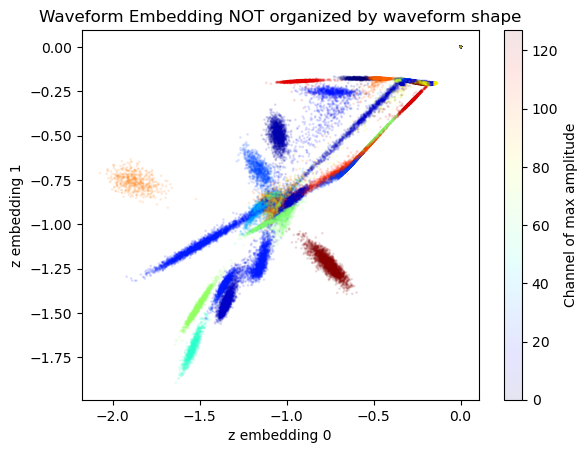

In [110]:
z = analysis.z
# z = pca.transform(z)
ids = mark_ids[1:]
feature = template_waveforms[ids].argmax(axis=1)[::subset]
plt.scatter(z[::subset, 0], z[::subset, 1], s=1, alpha=0.1, c=feature, cmap="jet")
plt.colorbar(label="Channel of max amplitude")
plt.xlabel("z embedding 0")
plt.ylabel("z embedding 1")

plt.title("Waveform Embedding NOT organized by waveform shape")

Text(0.5, 1.0, 'Waveform Embedding IS organized by tuning features')

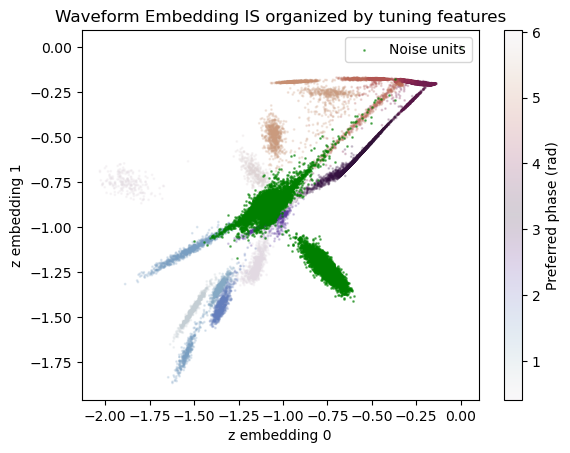

In [108]:
ids = mark_ids[1:]

ind = np.where(ids < mark_ids.max() - n_noise_units)[0][::subset]
feature = tuning_curves["theta_max"][ids]

ind = np.where(ids < mark_ids.max() - n_noise_units)[0][::subset]
plt.scatter(z[ind, 0], z[ind, 1], s=1, alpha=0.2, c=feature[ind], cmap="twilight")
plt.colorbar(label="Preferred phase (rad)")

ind = np.where(ids >= mark_ids.max() - n_noise_units)[0]
plt.scatter(z[ind, 0], z[ind, 1], s=1, alpha=0.5, c="green", label="Noise units")
plt.legend(loc=1)


plt.xlabel("z embedding 0")
plt.ylabel("z embedding 1")

plt.title("Waveform Embedding IS organized by tuning features")

In [103]:
i = 13  # example neuron

# Find neuron with similar tuning curve
peak = tuning_curves["theta_max"][i]
target_peak = peak + 0.5
i_tuning = np.argmin((tuning_curves["theta_max"] - target_peak) ** 2)

# Find neuron with similar waveform
peak = np.argmax(template_waveforms[i])
target_peak = peak + 10
i_waveform = np.argmin((template_waveforms.argmax(axis=1) - target_peak) ** 2)

samples = [i, i_tuning, i_waveform, n_units - 10]

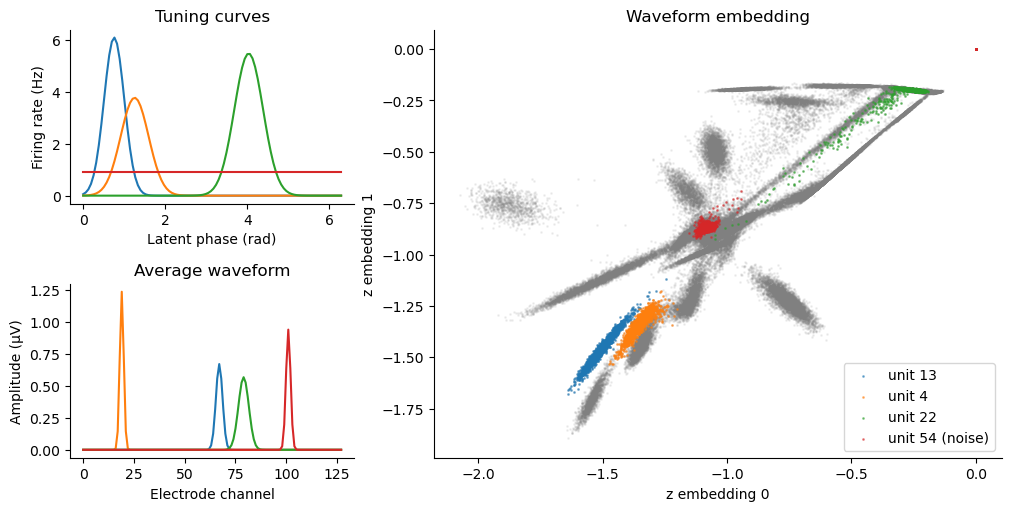

In [ ]:
from matplotlib.gridspec import GridSpec
from src.c3po.toy_model_generators.phase import gaussian

fig = plt.figure(constrained_layout=True, figsize=(10, 5))
gs = GridSpec(2, 3, figure=fig)
tuning_ax = fig.add_subplot(gs[0, 0])
waveform_ax = fig.add_subplot(gs[1, 0])
embedding_ax = fig.add_subplot(gs[:, 1:])

for i_ in samples:
    theta_bins = np.linspace(0, 2 * np.pi, 100)
    tuning_curve_i = (
        gaussian(theta_bins, tuning_curves["theta_max"][i_], tuning_curves["sigma"][i_])
        * tuning_curves["amplitude"][i_]
    )
    if i_ >= n_units - n_noise_units:
        rate = np.where(ids == i_)[0].shape[0] / (t_max)
        tuning_curve_i = np.ones_like(tuning_curve_i) * rate

    tuning_ax.plot(theta_bins, tuning_curve_i)

    waveform_ax.plot(
        template_waveforms[i_].T,
    )

z = analysis.z
ids = mark_ids[1:]
embedding_ax.scatter(z[:, 0], z[:, 1], s=1, alpha=0.1, c="grey")
for i_, c_ in zip(samples, ["C0", "C1", "C2", "C3"]):
    embedding_ax.scatter(
        z[ids == i_, 0],
        z[ids == i_, 1],
        s=1,
        alpha=0.5,
        c=c_,
        label=f"unit {i_}{' (noise)' if i_ >= n_units - n_noise_units else ''}",
    )

tuning_ax.set_xlabel("Latent phase (rad)")
tuning_ax.set_ylabel("Firing rate (Hz)")
tuning_ax.spines[["top", "right"]].set_visible(False)
tuning_ax.set_title("Tuning curves")

waveform_ax.set_xlabel("Electrode channel")
waveform_ax.set_ylabel("Amplitude (µV)")
waveform_ax.spines[["top", "right"]].set_visible(False)
waveform_ax.set_title("Average waveform")

embedding_ax.set_xlabel("z embedding 0")
embedding_ax.set_ylabel("z embedding 1")
embedding_ax.spines[["top", "right"]].set_visible(False)
embedding_ax.set_title("Waveform embedding")
embedding_ax.legend(loc=4)